In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import IterableDataset
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorboard
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
import tensorflow
import math
import datetime

# check GPU is enabled
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



Wed May 10 03:27:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

PATH=r"/content/drive/MyDrive/Marquette Grad School/Deep_Generative_CT_Challenge/"

class CT_Dataset(Dataset):
    def __init__(self,dataset_type):
        if dataset_type == 'train':
          self.imgs_path = PATH+"challenge_data/"
        if dataset_type == 'fake':
          self.imgs_path = PATH+"generated_images/"
        if dataset_type == 'fake_workable':
          self.imgs_path = PATH+"generated_images_workable/"
        if dataset_type == 'fake_best':
          self.imgs_path = PATH+"generated_images_best_long/"
        if dataset_type == 'best_long_1':
          self.imgs_path = PATH+"generated_images_best_long_1/"
        if dataset_type == 'best_long_2':
          self.imgs_path = PATH+"generated_images_best_long_2/"
        if dataset_type == 'best_long_2LR':
          self.imgs_path = PATH+"generated_images_best_long_12LR/"
        if dataset_type == 'final':
          self.imgs_path = PATH+"generated_final/"
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        #num_folders=20
        
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            f=0 #counter for number of images so far
            for img_path in glob.glob(class_path + "/*.png"):
                self.data.append([img_path, 'true_CT'])
                f+=1
                #if f==990: break #make sure number of images is divisble by 5
            #print(f"folder {class_name}, num images {f}, {img_path}")
            #if f == 960: break
        #print(f, len(self.data))
        self.class_map = {"fake_CT" : 0, "true_CT": 1}
        self.img_dim = (512, 512)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        #print(f"img loaded {img.size}")
        if img is None: #img.size !=786432):
          print('bad file', img_path)
          return self.__getitem__(idx+1)   
        #img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor=torch.as_tensor(img/255.,dtype=torch.float)
        img_tensor = img_tensor.permute(2, 0, 1)
        #rescale images from [0,1] to [-1,1] scale
        #img_tensor = (img_tensor-0.5)/0.5
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

trainset=CT_Dataset('train')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/Marquette Grad School/Deep_Generative_CT_Challenge/challenge_data/00000', '/content/drive/MyDrive/Marquette Grad School/Deep_Generative_CT_Challenge/challenge_data/00001', '/content/drive/MyDrive/Marquette Grad School/Deep_Generative_CT_Challenge/challenge_data/00002', '/content/drive/MyDrive/Marquette Grad School/Deep_Generative_CT_Challenge/challenge_data/00003', '/content/drive/MyDrive/Marquette Grad School/Deep_Generative_CT_Challenge/challenge_data/00004', '/content/drive/MyDrive/Marquette Grad School/Deep_Generative_CT_Challenge/challenge_data/00005', '/content/drive/MyDrive/Marquette Grad School/Deep_Generative_CT_Challenge/challenge_data/00006', '/content/drive/MyDrive/Marquette Grad School/Deep_Generative_CT_Challenge/challenge_data/00007', '/content/drive/MyDrive/Marquette Grad School/Deep_Generative_CT_Challenge/challenge_d

Define torch data loaders

In [ ]:
batch_size = 5 #number of images to load in each training iteration (maybe increase to 64?)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                               shuffle=True, num_workers=1)


Visualize an example of training data (just for reference)

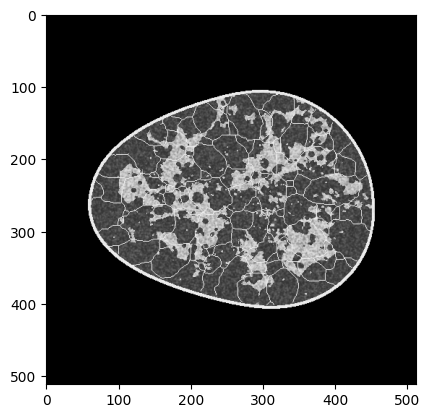

In [ ]:
from matplotlib.transforms import Transform
images, labels = next(iter(train_dataloader))
#print(images.shape, images.type())
#print(len(train_dataloader))
#print(images[0].permute(1,2,0).shape)
plt.imshow(images[0].permute(1,2,0))

Define neural net model classes


In [ ]:
#ngpu = device (1=gpu, 0=cpu)
#nz = length of length of input vector
#ngf/ndf=feature map size
#nc=number of channels (1 for black and white)

if device=='cpu':
  ngpu=0
else:
  ngpu=1
ngf=512
ndf=512 #128 #512
nc=3
nz=100

#for conv2d input torch format is [batch_size, channels, height, width] ie [64,3,512,512]
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf*8, 4, 1, 0, bias=False), #(in_channels=100,out_channels=4096, kernal size (4, 4), stride(1,1), padding=0)
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4=4096x4x4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 4, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            #state size (ngf*4)x2048x8x8
            nn.ConvTranspose2d( ngf*4, ngf * 2, 4, 4, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16=1024 x 16 x16    
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 4, 0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32 = 512 x 32 x32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            #nn.LeakyReLU(0.2, inplace=True),  #adding an extra relu layer here effectively clips output to [0.1], without this outputs are [-1,1]
            nn.Tanh(),
            #TRY ADDING A ReLU layer here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            nn.ReLU(False)
            # state size. (nc) x 64 x 64= 3 x 64 x64

        )

    def forward(self, input):
        #print(input.type)
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 4, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf *4, 4, 4, 1, bias=False),
            nn.BatchNorm2d(ndf *4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 4, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        #print(input.type)
        return self.main(input)



Option 2:Initialize model by loading weights from previous training

In [ ]:
#initialize weights based on saved training weights

generator= Generator(ngpu)
generator = generator.to(device)

discriminator = Discriminator(ngpu)
discriminator = discriminator.to(device)

#PATH = "/content/drive/MyDrive/Marquette Grad School/ct_gan_weights_workable.pth"  #

PATH = "/content/drive/MyDrive/Marquette Grad School/ct_gan_weights_best_long_1.pth"  #
#PATH = "/content/drive/MyDrive/Marquette Grad School/ct_gan_weights_best_long_2LR_retrain.pth" 
trained_weights=torch.load(PATH,map_location=torch.device(device))
generator.load_state_dict(trained_weights['generator_dict'])
discriminator.load_state_dict(trained_weights['discriminator_dict'])

<All keys matched successfully>

In [ ]:
print(generator)
print(discriminator)

In [ ]:
#########Define metrics functions

def load_data(path, num_images):
    fake_dataset = CT_Dataset('fake')
    fake_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                               shuffle=True, num_workers=1)
    loaded_images = 0
    fata_data = np.empty([num_images, 3, 512, 512]) #[] #np.zeros((num_images, 3, 512, 512), dtype=np.uint8)
    while loaded_images < num_images:
      images, labels = next(iter(train_dataloader))
      for j in range(batch_size):
        fake_data[loaded_images] = images[j]*255
        loaded_images+=1
    

    return fake_data #fnames, data

def public_features(data):
    
    phantom_mask_g45 = np.zeros_like(data)
    phantom_mask_l120= np.zeros_like(data)
    phantom_mask_l226 = np.zeros_like(data)

    if np.max(data) <= 1:
      data_scaled = data*255.
    else:
      data_scaled = data
  
    for i in range(data_scaled.shape[0]):
      p_image = data_scaled[i]
  
      p_mask_1 = p_image >= 45
      p_mask_2 = p_image < 120
      p_mask_3 = p_image < 226
   
      phantom_mask_g45[i]=p_mask_1
      phantom_mask_l120[i]=p_mask_2
      phantom_mask_l226[i]=p_mask_3

  
    print(phantom_mask_g45.shape)
    print("Computing slice areas")
    areas = np.sum(phantom_mask_g45) #,axis=(2,3,1))
    non_phantom_area = num_images*3*512*512-areas
   

    print("Computing fat area")
    fat_areas = np.sum(phantom_mask_l120)-non_phantom_area #,axis=(2,3,1))
    print(fat_areas)
  

    print("Computing glandular area")
    gln_areas = num_images*3*512*512 - np.sum(phantom_mask_l226) #, axis=(2,3,1))
    print(f"phantom area {areas}, fat area {fat_areas}, gln area {gln_areas}")
    print(gln_areas)

    print("Computing fat to glandular ratio")
    fg_ratios = np.log10( fat_areas / gln_areas )
    
    N = len(data)
    data = data.reshape(N, -1)
    #data = data #\255.
    
    print("Computing means ...")
    means = np.mean(data, axis=1)

    print("Computing stds ...")
    stds = np.std(data, axis=1)

    print("Computing skewnesses ...")
    skewnesses = stats.skew(data, axis=1)

    print("Computing kurtoses ...")
    kurtoses = stats.kurtosis(data, axis=1)

    print("Computing balances")
    balances = ( np.quantile(data, 0.7, axis=1) - np.mean(data, axis=1) ) \
                / ( np.mean(data, axis=1) - np.quantile(data, 0.3, axis=1) )
                
    return {'mean'      : means,
            'std'       : stds, 
            'skewness'  : skewnesses,
            'kurtosis'  : kurtoses,
            'balance'   : balances,

            'area'      : areas,
            'fat_area'  : fat_areas,
            'gln_area'  : gln_areas,
            'fg_ratio'  : fg_ratios,
            }


Generate and save some images for evaluation


In [ ]:

import time


def generate_breast_ct(num_images, weight_file_path, output_file_path):
  '''
  Loads a pre-trained generative neural network and uses it to generate and
  store num_images 512x512 breast ct slices
  '''

  generator_nn=Generator(ngpu).to(device)
  #PATH_2 = "/content/drive/MyDrive/Marquette Grad School/ct_gan_weights_workable.pth" 
  trained_weights=torch.load(weight_file_path, map_location=torch.device(device))
  generator_nn.load_state_dict(trained_weights['generator_dict'])

  start_time=time.time()
  num_batches=np.ceil(num_images/batch_size)
  num_batches=int(num_batches)
  index=0
  for i in range(num_batches):
    noise = torch.randn(100 * batch_size,dtype=torch.float32)
    #reshape into a batch of 8 grayscale images
    noise=noise.reshape((batch_size, 100,1, 1))
    new_images=generator_nn(noise.to(device))
    
    #save generated images as .png files in PATH folder
    for j in range(batch_size):
      plt.imshow(new_images[j,:,:,:].cpu().detach().permute(1,2,0))
      plt.savefig(f"{output_file_path}/ct_image_{index}.png")
      index+=1
  stop_time=time.time()
  print(f"{num_images} generated and saved in {stop_time-start_time} seconds")

define fid metric

In [ ]:
'''
From https://github.com/tsc2017/Frechet-Inception-Distance
Code derived from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/eval/python/classifier_metrics_impl.py

Usage:
    Call get_fid(images1, images2)
Args:
    images1, images2: Numpy arrays with values ranging from 0 to 255 and shape in the form [N, 3, HEIGHT, WIDTH] where N, HEIGHT and WIDTH can be arbitrary. 
    dtype of the images is recommended to be np.uint8 to save CPU memory.
Returns:
    Frechet Inception Distance between the two image distributions.
'''

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
import functools
import numpy as np
import time
from tensorflow.python.ops import array_ops
!pip install tensorflow-gan
import tensorflow_gan as tfgan

session=tf.compat.v1.InteractiveSession()
# A smaller BATCH_SIZE reduces GPU memory usage, but at the cost of a slight slowdown
BATCH_SIZE = 64

# Run images through Inception.
inception_images = tf.compat.v1.placeholder(tf.float32, [None, 3, None, None], name = 'inception_images')
activations1 = tf.compat.v1.placeholder(tf.float32, [None, None], name = 'activations1')
activations2 = tf.compat.v1.placeholder(tf.float32, [None, None], name = 'activations2')
fcd = tfgan.eval.frechet_classifier_distance_from_activations(activations1, activations2)

INCEPTION_TFHUB = 'https://tfhub.dev/tensorflow/tfgan/eval/inception/1'
INCEPTION_FINAL_POOL = 'pool_3'

def inception_activations(images = inception_images, num_splits = 1):
    images = tf.transpose(images, [0, 2, 3, 1])
    size = 299
    images = tf.compat.v1.image.resize_bilinear(images, [size, size])
    generated_images_list = array_ops.split(images, num_or_size_splits = num_splits)
    activations = tf.map_fn(
        fn = tfgan.eval.classifier_fn_from_tfhub(INCEPTION_TFHUB, INCEPTION_FINAL_POOL, True),
        elems = array_ops.stack(generated_images_list),
        parallel_iterations = 1,
        back_prop = False,
        swap_memory = True,
        name = 'RunClassifier')
    activations = array_ops.concat(array_ops.unstack(activations), 0)
    return activations

activations =inception_activations()

def get_inception_activations(inps):
    n_batches = int(np.ceil(float(inps.shape[0]) / BATCH_SIZE))
    act = np.zeros([inps.shape[0], 2048], dtype = np.float32)
    for i in range(n_batches):
        inp = inps[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] / 255. * 2 - 1
        act[i * BATCH_SIZE : i * BATCH_SIZE + min(BATCH_SIZE, inp.shape[0])] = session.run(activations, feed_dict = {inception_images: inp})
    return act

def activations2distance(act1, act2):
    return session.run(fcd, feed_dict = {activations1: act1, activations2: act2})
        
def get_fid(images1, images2):
    session=tf.get_default_session()
    assert(type(images1) == np.ndarray)
    assert(len(images1.shape) == 4)
    assert(images1.shape[1] == 3)
    assert(np.min(images1[0]) >= 0 and np.max(images1[0]) > 10), 'Image values should be in the range [0, 255]'
    assert(type(images2) == np.ndarray)
    assert(len(images2.shape) == 4)
    assert(images2.shape[1] == 3)
    assert(np.min(images2[0]) >= 0 and np.max(images2[0]) > 10), 'Image values should be in the range [0, 255]'
    assert(images1.shape == images2.shape), 'The two numpy arrays must have the same shape'
    print('Calculating FID with %i images from each distribution' % (images1.shape[0]))
    start_time = time.time()
    act1 = get_inception_activations(images1)
    act2 = get_inception_activations(images2)
    fid = activations2distance(act1, act2)
    print('FID calculation time: %f s' % (time.time() - start_time))
    return fid

Instructions for updating:
non-resource variables are not supported in the long term


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 27.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/nest.py:917: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  structure[0], [func(*x) for x in entries],


Function to run metrics and generate plots

In [ ]:

import argparse
import numpy as np
from scipy import stats
import glob
import os
import os.path as p
import imageio as io
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import ks_2samp
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

pd.set_option('use_inf_as_na', True) # All infs throughout are set to nans

data_name='downsized_victre_xray_objects2'


def run_metrics(gen_dist, num_images, results_dir):
  '''
  gen_dist = 'fake', 'fake_workable', 'fake_best'
  num_images = number of existing generated images to use as the basis of the sample
  '''
  levels=64
  pca_components=9
  to_save_pva_plots=1
  to_save_cose_plots=1
  num_random_runs = 100000


  # load real or fake data
  


  print(np.max(real_data), np.max(fake_data))
  fid = get_fid(real_data*255., fake_data*255.)
  print(f'fid score = {fid}')
  # Evaluate the public metrics
  real_features = public_features(real_data) #*255.)
  fake_features = public_features(fake_data) #*255.)


  real_df = pd.DataFrame.from_dict(real_features).fillna(0)
  fake_df = pd.DataFrame.from_dict(fake_features).fillna(0)
  
  print("Computing real PCA")
  # PCA the reals and store the PCA'd values in a dataframe
  scalar = StandardScaler()
  real_np = real_df.to_numpy()
  scalar.fit(real_np)
  R_scaled = scalar.transform(real_np)
  pca = PCA(n_components=pca_components, random_state = 1000)
  R_pca = pca.fit_transform(R_scaled)
  dfr_pca = pd.DataFrame(R_pca)

  print("Projecting fake data onto the real PC components")
  fake_np = fake_df.to_numpy()
  F_scaled = scalar.transform(fake_np)
  F_pca = pca.transform(F_scaled)
  dff_pca = pd.DataFrame(F_pca)

  # Compute pairwise cosine distances for the reals
  print("Computing pairwise cosine distances for the reals")
  real_cosines = []
  for i in range(num_random_runs):
    print(f'{i}/{num_random_runs}', end='\r')

    sampled = dfr_pca.sample(n=2, replace=False).to_numpy()
    real_cosines.append( np.dot(sampled[0,:], sampled[1,:]) / (np.linalg.norm(sampled[0,:])*np.linalg.norm(sampled[1,:])) )

  # Compute pairwise cosine distances for real-fake point pairs
  print("Computing pairwise cosine distances for real-fake point pairs")
  mixed_cosines = []
  for i in np.arange(num_random_runs):
    sampledr = dfr_pca.sample(n=1, replace=False).to_numpy()
    sampledf = dff_pca.sample(n=1, replace=False).to_numpy()
    mixed_cosines.append( np.dot(sampledr[0,:], sampledf[0,:]) / (np.linalg.norm(sampledr[0,:])*np.linalg.norm(sampledf[0,:])) )
  mixed_cosines = mixed_cosines*100000
  # Compute KS statistic on the reals and the mixed distributions of cosine similarities.
  print("Compute KS statistic")
  ks_stat,ks_pval = ks_2samp(real_cosines, mixed_cosines) # This will slightly vary over multiple runs, probably in the second decimal place.
  print(f"KS statistic : {ks_stat} KS p-value: {ks_pval}")
  ks_stat_str = f'{ks_stat:.3f}'

  #if to_save_pca_plots:
  print("Saving PCA plots")
  plt.figure()
  plt.scatter(F_pca[:1000,0], F_pca[:1000,1], color='red', alpha=0.2, label='fake')
  plt.scatter(R_pca[:1000,0], R_pca[:1000,1], color='green', alpha=0.2, label='real')
  plt.xlim(-10, 10)
  plt.ylim(-10, 10)
  plt.xlabel('PC 1')
  plt.ylabel('PC 2')
  plt.title('PCA')
  plt.legend()
  plt.savefig(p.join(results_dir, f'crop_20pca.png'))
  plt.show()
  plt.close()

  print(np.max(real_cosines), np.max(mixed_cosines))
  #if to_save_cosine_plots:
  import seaborn as sns
  print("Saving cosine plots")
  plt.figure()
  sns.kdeplot(np.array(real_cosines), label='real')
  sns.kdeplot(np.array(mixed_cosines), label='mixed')
  plt.ylim([0,1])
  plt.ylabel('density')
  plt.xlabel('cosine similarity')
  plt.title(f'KS statistic : {ks_stat_str}')
  plt.legend()
  plt.savefig(p.join(results_dir, f'10cosine.png'))
  plt.show()
  plt.close()

  with open(p.join(results_dir, f'public_metric.txt'), 'w') as fid:
    fid.write(f"KS statistic   : {ks_stat:.6f}, p-value {ks_pval}")
